<a href="https://www.kaggle.com/mohamedkhaled201841/single-object-detection-without-yolo-acc-71?scriptVersionId=86170153" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

The main topic of these Notebook is single object detection, which means getting a model to draw a box around every key object in an image, and label each one correctly.  we can use transfer learning from an <b>ImageNet</b> classifier that was never even trained to do detection.We are going to follow these steps:
- Classify the biggest object
- Predict Bounding box of biggest object
- Put all together to predict and classify the biggest object

we’ll use a single model to do both these at the same time.

###upgrade and import some packages

In [1]:
! pip install --upgrade git+https://github.com/keras-team/keras.git \
                        git+https://github.com/valeoai/dl_utils.git \
                        imageio

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-yey2139n
  Running command git clone --filter=blob:none -q https://github.com/keras-team/keras.git /tmp/pip-req-build-yey2139n
  Resolved https://github.com/keras-team/keras.git to commit 85ccb4e108551b7444213276ffb4c4c09f22f886
ERROR: git+https://github.com/keras-team/keras.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import keras
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dropout, Flatten,Dense
from tensorflow.keras.optimizers import Adam

import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image



## Pascal VOC
We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. later we can use the larger 2012 for better results.



In [15]:
import os
if not os.path.isdir('./VOCdevkit/'):
    ! wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
    ! tar -xf VOCtrainval_06-Nov-2007.tar
    #! wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
    #! unzip -q PASCAL_VOC.zip -d VOCdevkit/VOC2007
    #! rm -Rf VOCdevkit/VOC2007/PASCAL_VOC
    !mv  ../input/pascal-voc-2007/PASCAL_VOC/PASCAL_VOC/pascal_train2012.json VOCdevkit/VOC2007/pascal_train2007.json
      

In [27]:
 !mv  ../input/pascal-voc-2007/PASCAL_VOC/PASCAL_VOC/pascal_train2007.json VOCdevkit/VOC2007/pascal_train2007.json

mv: cannot remove '../input/pascal-voc-2007/PASCAL_VOC/PASCAL_VOC/pascal_train2007.json': Read-only file system


In [28]:
from pathlib import Path

PATH = Path('VOCdevkit/VOC2007/')
for i in PATH.iterdir(): print(i)
    
JPEGS = PATH/'JPEGImages'

VOCdevkit/VOC2007/JPEGImages
VOCdevkit/VOC2007/Annotations
VOCdevkit/VOC2007/SegmentationClass
VOCdevkit/VOC2007/ImageSets
VOCdevkit/VOC2007/SegmentationObject
VOCdevkit/VOC2007/pascal_train2007.json


so, you have:
- <kbd>JPEGImages</kbd> folder containing all the images
- <kbd>Annotations</kbd> folder containing all the annotation, one XML annotation file per image file

The original version were in XML, which is a little hard to work with nowadays, so we use the more recent JSON version

In [29]:
import json
BD = json.load((PATH/'pascal_train2007.json').open()) # it loads a dictionary
print('the dictionary of keys: ',BD.keys())

the dictionary of keys:  dict_keys(['images', 'type', 'annotations', 'categories'])


In [30]:
# Then, we can acces to the image
BD['images'][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [31]:
# The annotations
BD['annotations'][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [32]:
# and all category
BD['categories']

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'},
 {'supercategory': 'none', 'id': 8, 'name': 'cat'},
 {'supercategory': 'none', 'id': 9, 'name': 'chair'},
 {'supercategory': 'none', 'id': 10, 'name': 'cow'},
 {'supercategory': 'none', 'id': 11, 'name': 'diningtable'},
 {'supercategory': 'none', 'id': 12, 'name': 'dog'},
 {'supercategory': 'none', 'id': 13, 'name': 'horse'},
 {'supercategory': 'none', 'id': 14, 'name': 'motorbike'},
 {'supercategory': 'none', 'id': 15, 'name': 'person'},
 {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'},
 {'supercategory': 'none', 'id': 17, 'name': 'sheep'},
 {'supercategory': 'none', 'id': 18, 'name': 'sofa'},
 {'super

### show some images

In [33]:
import collections

def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# we convert categories into dictionary
data_category = dict((o['id'],o['name']) for o in BD['categories']) # all the categories
data_filename = dict((o['id'],o['file_name']) for o in BD['images']) # image id to image filename
data_ids = [o['id'] for o in BD['images']] # list of all the image IDs

annotations = collections.defaultdict(lambda:[])
for o in BD['annotations']:
    if not o['ignore']:
        bb = o['bbox']
        bb = hw_bb(bb)
        annotations[o['image_id']].append((bb,o['category_id']))
        
print('we have',len(BD['annotations']),'annotations')

we have 7844 annotations


## some convenient display functions

In [34]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def show_img(im, figsize=None, ax=None):
    """show images"""
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
  
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    """Draw rectangle around the object of interest"""
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    """Write the text on the upper right corner of rectangle surrounding the object"""
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)    
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8)) # That's why the image with draw_im is zoomed in
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], data_category[c], sz=16)
        
def draw_idx(i):
    im_a = annotations[i]
    im = image.imread(JPEGS/data_filename[i])
    draw_im(im, im_a)    

### Use the preivious functions

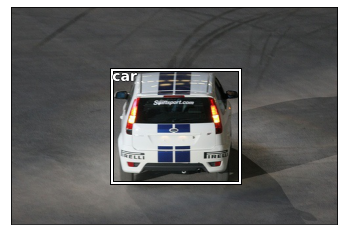

In [35]:
im = image.imread(JPEGS/data_filename[data_ids[0]])
    
ax = show_img(im)
bbox = annotations[data_ids[0]][0][0]
clas_id = annotations[data_ids[0]][0][1]
bbox = bb_hw(bbox)

draw_rect(ax, bbox)
draw_text(ax, bbox[:2], data_category[clas_id])    

## Step 1: Largest item classifier

We are going to create a classifier to predict the class of the biggest object in the image. 
For that purpose, we need to structure our learning data in a scalable manner as we will, step by step, increase the complexity of our task.

### Setup the data folder
___copy vs. point___

__Flow from directory means to copy__

So, there are plenty of way to do that, but in Fast.ai, they use a csv file to list all images/labels instead of creating a new directory and copying inside all the needed data. For sure, it sounds better than recreating a folder and copying all the need images and labels... not really convenient, neither scalable. And finally, they have this nice function to train directly from a CSV file. 

__Flow from dataframe__
In August 2018, Keras came with a super usefull function called <kbd>flow_from_dataframe</kbd>!!! Great, no more code to do, it is a method from <kbd>ImageDataGenerator</kbd>, and uses same properties, that is to say we can even do Data AUgmentation!

So, before doing anything with the data, that is to say jump to the conclusion, we have first to figure out how we will provide the data to our network. As we said before, Keras can use Dataframe to represent the data.

What do we put them in our dataframe? We want for each image to have a classification tag. Sounds pretty easy, right?

So,it's supposed to look like this

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/06_Single_Object_Detection/dataframe.png" width="30%">

Let's do it now!

In [36]:
import pandas as pd

def get_largest_annotation(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]


filename=[]
C=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    
    C.append(data_category[get_largest_annotation(annotation)[1]])
    
df = pd.DataFrame({'filename': filename, 'class': C}, columns=['filename','class'])

df[:5]

filename      class
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

### Split our data into training and validation set

In [37]:
# create a training and validation set

def Split_Train_Valid(df,Split_train_val=0.7):
    # step 1: shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    df=df.set_index(np.arange(len(df)))
    
    # step 2: split in training and testing
    df_train = df[:int(len(df)*Split_train_val)]
    df_valid = df[int(len(df)*Split_train_val):]
    df_train=df_train.set_index(np.arange(len(df_train)))
    df_valid=df_valid.set_index(np.arange(len(df_valid)))
    
    return df_train,df_valid

df_train, df_valid = Split_Train_Valid(df,0.7)

## Data augmentation
The easiest way to do Data Augmentation is to create an <kbd>ImageDataGenerator</kbd> and specify the transformation properties.  the data needs to be preprocessed to be compatible with the model used (VGG16). 

In [38]:
# our batch size
bs=32
# define the size of our input data
sz=224

# preprocess_input is for VGG16 in our case
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True) 

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 


train_batches = train_datagen.flow_from_dataframe(df_train, # The df
                                                  JPEGS, # Place on desk
                                                  x_col='filename', # The column to get x
                                                  y_col='class', # The column to get y
                                                  has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=None, 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=True)



valid_batches = valid_datagen.flow_from_dataframe(df_valid, 
                                                  JPEGS, 
                                                  x_col='filename', 
                                                  y_col='class', 
                                                  has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=list(train_batches.class_indices), 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=False)

NbClasses = len(train_batches.class_indices)

Found 1750 validated image filenames belonging to 20 classes.
Found 751 validated image filenames belonging to 20 classes.


--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/root/.local/lib/python3.7/site-packages/log.py", line 16, in format
    msg = super(_LogFormatter, self).format(record)
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_

###  Create our model

it will be a VGG16 model.

In [39]:
net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
        
# we add our classification layer
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NbClasses, activation='softmax', name='softmax')(x)
model = Model(inputs=net.input, outputs=output_layer)
model.summary()

2022-01-26 00:05:24.963904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 00:05:25.049249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 00:05:25.049971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 00:05:25.051258: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

### Define an optimizer and a Loss function

In [40]:
epochs = 20

opt = Adam(lr=1e-4)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### It is time to train now

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-01-26 00:05:28.280877: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-01-26 00:05:30.226460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


54/54 [==============================] - 38s 524ms/step - loss: 25.4818 - accuracy: 0.1892 - val_loss: 12.9824 - val_accuracy: 0.4239
Epoch 2/20
54/54 [==============================] - 27s 493ms/step - loss: 16.5979 - accuracy: 0.3620 - val_loss: 9.2327 - val_accuracy: 0.5394
Epoch 3/20
54/54 [==============================] - 27s 500ms/step - loss: 13.1061 - accuracy: 0.4546 - val_loss: 8.1587 - val_accuracy: 0.6101
Epoch 4/20
54/54 [==============================] - 26s 489ms/step - loss: 10.3684 - accuracy: 0.5221 - val_loss: 7.6503 - val_accuracy: 0.6345
Epoch 5/20
54/54 [==============================] - 27s 503ms/step - loss: 8.8255 - accuracy: 0.5838 - val_loss: 7.1359 - val_accuracy: 0.6495
Epoch 6/20
54/54 [==============================] - 27s 509ms/step - loss: 7.6419 - accuracy: 0.6001 - val_loss: 6.6903 - val_accuracy: 0.6889
Epoch 7/20
54/54 [==============================] - 27s 506ms/step - loss: 6.7657 - accuracy: 0.6484 - val_loss: 6.7311 - val_accuracy: 0.6889
Epoch

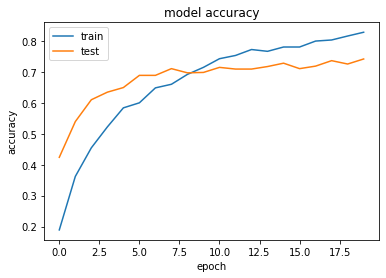

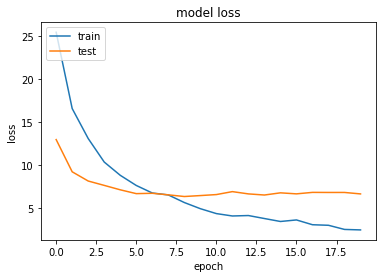

In [41]:
history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### unfreeze couple of layers for better learning and enhance the accuracy


In [42]:
#unfreeze initial layers
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Train again

Epoch 1/10
54/54 [==============================] - 28s 505ms/step - loss: 2.2089 - accuracy: 0.8295 - val_loss: 5.8448 - val_accuracy: 0.7242
Epoch 2/10
54/54 [==============================] - 27s 506ms/step - loss: 1.8199 - accuracy: 0.8359 - val_loss: 5.3701 - val_accuracy: 0.7269
Epoch 3/10
54/54 [==============================] - 27s 504ms/step - loss: 1.7962 - accuracy: 0.8184 - val_loss: 4.9705 - val_accuracy: 0.7079
Epoch 4/10
54/54 [==============================] - 27s 498ms/step - loss: 1.6275 - accuracy: 0.8271 - val_loss: 4.5587 - val_accuracy: 0.7133
Epoch 5/10
54/54 [==============================] - 28s 510ms/step - loss: 1.4233 - accuracy: 0.8347 - val_loss: 4.4720 - val_accuracy: 0.7201
Epoch 6/10
54/54 [==============================] - 27s 506ms/step - loss: 1.4043 - accuracy: 0.8300 - val_loss: 4.3057 - val_accuracy: 0.7283
Epoch 7/10
54/54 [==============================] - 27s 503ms/step - loss: 1.3471 - accuracy: 0.8388 - val_loss: 4.0841 - val_accuracy: 0.7215

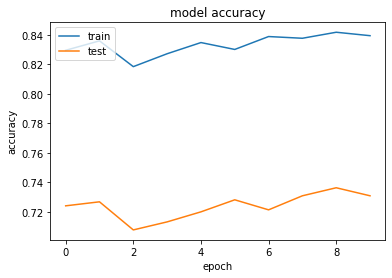

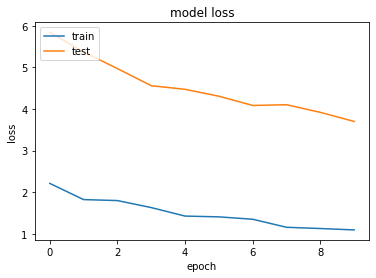

In [44]:
epochs = 10

opt = Adam(lr=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Check the result
unprocess function is just to inverse what preprocess_fct or preprocess_input (of VGG for for example) dir. Like normalization (multiply by std and add back the mean), or clipping (*255 again)

In [45]:
def unpreprocess(x, data_format,mode):
    """unpreprocesses a Numpy array encoding a batch of images.
    # Arguments
        x: Input array, 3D or 4D.
        data_format: Data format of the image array.
        mode: One of "caffe", "tf" or "torch".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.
    # Returns
        unreprocessed Numpy array.
    """
    if not issubclass(x.dtype.type, np.floating):
        x = x.astype(backend.floatx(), copy=False)

    im = np.copy(x) 

    if mode == 'tf':
        im += 1.
        im *= 127.5
        im = np.clip(im, 0, 255)
        return im.astype(np.uint8)

    if mode == 'torch':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        mean = [103.939, 116.779, 123.68]
        std = None

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if im.ndim == 3:
            if std is not None:
                im[0, :, :] *= std[0]
                im[1, :, :] *= std[1]
                im[2, :, :] *= std[2]
                
            im[0, :, :] += mean[0]
            im[1, :, :] += mean[1]
            im[2, :, :] += mean[2]

        else:
            if std is not None:
                im[:, 0, :, :] *= std[0]
                im[:, 1, :, :] *= std[1]
                im[:, 2, :, :] *= std[2]
                
            im[:, 0, :, :] += mean[0]
            im[:, 1, :, :] += mean[1]
            im[:, 2, :, :] += mean[2]

    else:
        if std is not None:
            im[..., 0] *= std[0]
            im[..., 1] *= std[1]
            im[..., 2] *= std[2]        
        im[..., 0] += mean[0]
        im[..., 1] += mean[1]
        im[..., 2] += mean[2]

    if mode == 'torch':
        im *= 255.
    else:
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if im.ndim == 3:
                im = im[::-1, ...]
            else:
                im = im[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            im = im[..., ::-1]
         
    im = np.clip(im, 0, 255)

    return im.astype(np.uint8) 

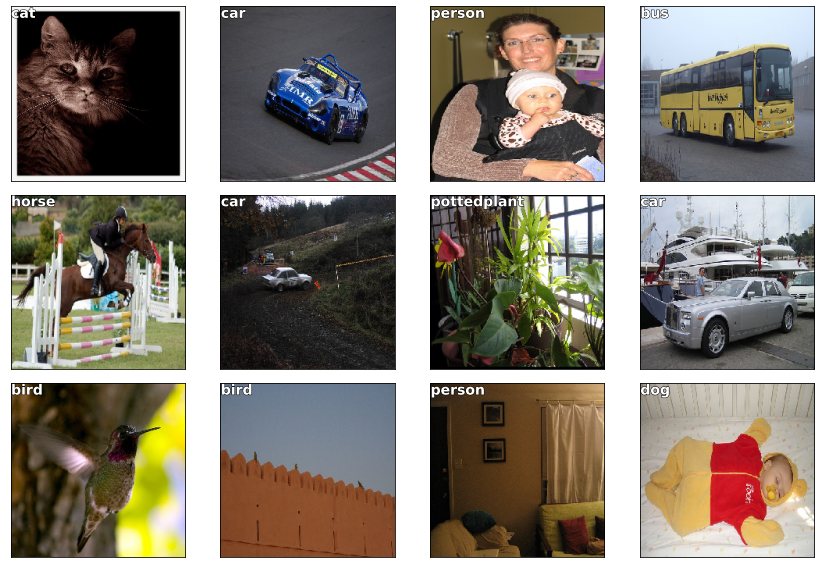

In [46]:


class_name = list(valid_batches.class_indices)

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    x,y = valid_batches.next()
    image = x[0]
    proba = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)
    class_id = np.argmax(proba)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_text(ax, (0,0), class_name[class_id])

plt.tight_layout()

## Step 2: Bbox regression
### 2.1: The Data
Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs.

In [47]:
# we create this time our data frame with the box coordiantes

filename=[]
bbox=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    bbox.append(get_largest_annotation(annotation)[0])
    
df = pd.DataFrame({'filename': filename, 'bbox': bbox}, columns=['filename','bbox'])

df[:5]

filename                 bbox
0  000012.jpg  [96, 155, 269, 350]
1  000017.jpg   [77, 89, 335, 402]
2  000023.jpg     [1, 2, 461, 242]
3  000026.jpg  [124, 89, 211, 336]
4  000032.jpg  [77, 103, 182, 374]

### create a training and validation set

In [48]:
df_train, df_valid = Split_Train_Valid(df,0.7)

# We cannot use data augmentation anymore!

Unfortunately, we can't really use as before the <kbd>flow_from_dataframe</kbd> function. There are several reasons, but the most important one is that we need to resize the image to fit to our input tensor and as a consequence, bounding boxes should be resized too!, To solve this problem we will  Make our own data generator!

In [49]:

class DataFrame_Generator(keras.utils.all_utils.Sequence):
    'Generates data from a Dataframe'
    def __init__(self, df, folder,preprocess_fct,batch_size=32, dim=(32,32), shuffle=True):
        'Initialization'
        self.preprocess_fct = preprocess_fct
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.folder = folder
    
        # Load the dataframe
        # the database is not so big, especially when resized in 224*224.
        # so we have either the option to load images online for each batch or
        # we can load all image at once 
        self.df = df
        self.n = len(df)            
        self.nb_iteration = int(np.floor(self.n  / self.batch_size))
        
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.nb_iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def __data_generation(self, index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3))
        Y = np.zeros((self.batch_size,4))

        # Generate data
        for i, ID in enumerate(index):
            # Read the image
            img = Image.open(self.folder/self.df['filename'][ID])
            bb = self.df['bbox'][ID]
                 
            # Resize according to the required size
            width, height = img.size
            RatioX = width/self.dim[0]
            RatioY = height/self.dim[1]
                                                        
            img = np.asarray(img.resize(self.dim))
            
            # Resize the bbox accordingly
            bb = [bb[0]/RatioY,bb[1]/RatioX,bb[2]/RatioY,bb[3]/RatioX]
                                 
            # Same as done for VGG16
            X[i,] = self.preprocess_fct(np.asarray(img))
            
            Y[i] = bb

        return X, Y 


In [50]:
train_gen = DataFrame_Generator(df_train,JPEGS,preprocess_input,bs,(sz,sz),True)
valid_gen = DataFrame_Generator(df_valid,JPEGS,preprocess_input,bs,(sz,sz),False)

### 2.2: The model

Here, we want to predict the position of the bounding box.
Actually, we expect our model to predict 4 values: this is a regression problem.

As the difference with Classification, we do not expect a probability but real position values! Our network will be the same as before (especially because we want to share latter the feature encoder part) but instead of adding a classifcation layer with a SoftMax or Sigmoid function (to provide a probability) we only need to add a linear layer

In [51]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
        
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='linear', name='linear')(x)
model = Model(inputs=net.input, outputs=output_layer) 
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### 2.3: The optimizer

Our optimizer will optimize the task our model is designed for. Compared to before, we used a Cross-entropy as our Loss function to predict Category. Now, as we want to predict continuous values, we are going to use L1 (mean_absolute_error) or L2 Loss (mean_squared_error)

In [52]:
optimizer=Adam(lr=1e-4)

model.compile(optimizer=optimizer,loss='mean_absolute_error', metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### 2.4: It's time to train

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
54/54 [==============================] - 19s 340ms/step - loss: 66.5542 - accuracy: 0.4850 - val_loss: 43.4484 - val_accuracy: 0.6005
Epoch 2/15
54/54 [==============================] - 18s 341ms/step - loss: 40.8623 - accuracy: 0.6244 - val_loss: 39.6233 - val_accuracy: 0.6495
Epoch 3/15
54/54 [==============================] - 18s 334ms/step - loss: 36.8490 - accuracy: 0.6476 - val_loss: 37.4764 - val_accuracy: 0.6739
Epoch 4/15
54/54 [==============================] - 18s 337ms/step - loss: 34.0999 - accuracy: 0.6644 - val_loss: 36.0891 - val_accuracy: 0.6821
Epoch 5/15
54/54 [==============================] - 18s 336ms/step - loss: 32.1390 - accuracy: 0.6823 - val_loss: 35.1085 - val_accuracy: 0.6929
Epoch 6/15
54/54 [==============================] - 18s 336ms/step - loss: 30.3772 - accuracy: 0.6910 - val_loss: 34.4960 - val_accuracy: 0.6984
Epoch 7/15
54/54 [==============================] - 18s 336ms/step - loss: 28.7114 - accuracy: 0.7211 - val_loss: 33.8027 - val_ac

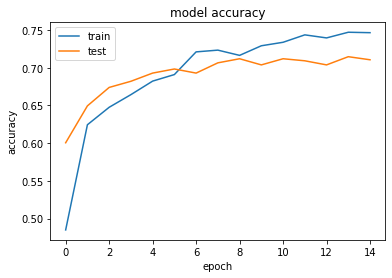

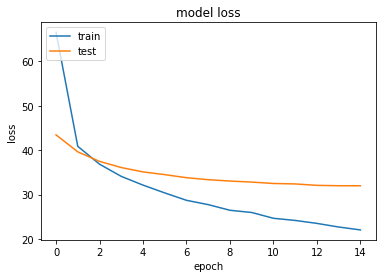

In [53]:
epochs = 15

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2.5: unfreeze couple of layers

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

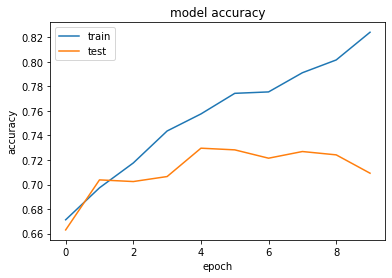

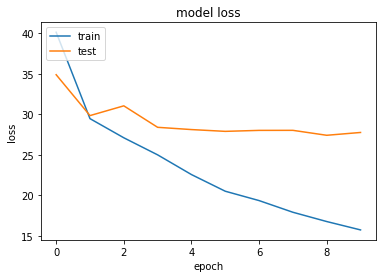

In [54]:
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
model.compile(optimizer=optimizer,loss='mean_absolute_error', metrics=['accuracy'])    

print(model.summary())

epochs = 10

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

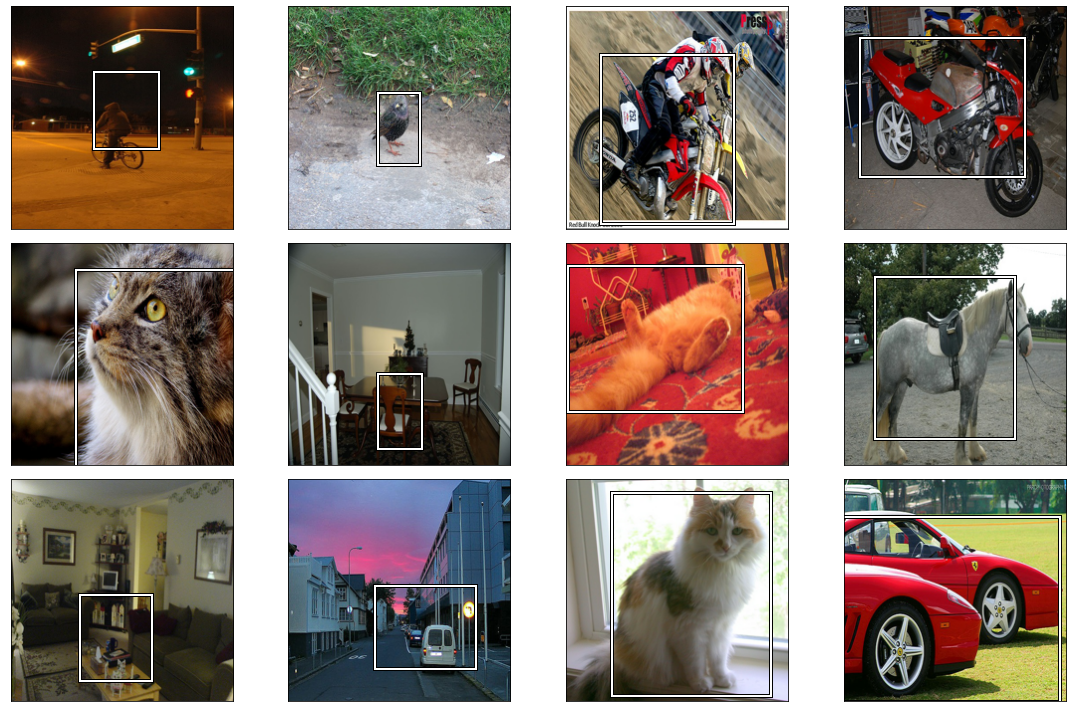

In [55]:
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
for i,ax in enumerate(axes.flat):
    x,y = next(iter(valid_gen))
    image = x[i]
    bb = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)

    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb[0]))

plt.tight_layout()

## Step 3: Single object detection

We have now to combine the two individual tasks of classification and detection we have developped bedore. We know that independently, it works. Therefore, if we modify accordingly our data, our model, our Loss function... it should work too!

let's go...

### 3.1: The Data

The data is still the image plus a tuple containing the bounding box coordinates and the category

In [56]:
df = pd.DataFrame({'filename': filename, 'cat':C, 'bbox': bbox}, columns=['filename','cat','bbox'])
df_train, df_valid = Split_Train_Valid(df,0.7)

In [57]:
class GeneratorSingleObject(keras.utils.all_utils.Sequence):
    """Generates data from a Dataframe"""

    def __init__(self, df, folder, preprocess_fct, batch_size=32, dim=(32, 32),
                 shuffle=True):
        'Initialization'
        self.preprocess_fct = preprocess_fct
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.folder = folder
        self.class_name = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
                           'car', 'cat', 'chair',
                           'cow', 'diningtable', 'dog', 'horse', 'motorbike',
                           'person', 'pottedplant', 'sheep',
                           'sofa', 'train', 'tvmonitor']
        self.NbClasses = len(self.class_name)
        self.class_dict = dict(
            (self.class_name[o], o) for o in range(self.NbClasses))

        self.df = df
        self.n = len(df)
        self.nb_iteration = int(np.floor(self.n / self.batch_size))

        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return self.nb_iteration

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index):
        """Generates data containing batch_size samples"""
        # Initialization
        # X: (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, *self.dim, 3))
        Y_bb = np.zeros((self.batch_size, 4))
        Y_clas = np.zeros((self.batch_size, 1))

        # Generate data
        for i, ID in enumerate(index):
            # Read the image
            img = Image.open(self.folder / self.df['filename'][ID])
            bb = self.df['bbox'][ID]
            #bb = np.fromstring(bb, dtype=np.int, sep=' ')

            width, height = img.size
            RatioX = width / self.dim[0]
            RatioY = height / self.dim[1]

            img = np.asarray(img.resize(self.dim))
            bb = [bb[0] / RatioY, bb[1] / RatioX, bb[2] / RatioY, bb[3] / RatioX]

            X[i] = self.preprocess_fct(np.asarray(img))
            Y_bb[i] = bb
            Y_clas[i] = self.class_dict[self.df['cat'][ID]]

        Y_clas = keras.utils.all_utils.to_categorical(Y_clas, self.NbClasses)

        return X, [Y_bb,Y_clas]




In [58]:
train_gen = GeneratorSingleObject(df_train,JPEGS,preprocess_input,bs,(sz,sz),True)
valid_gen = GeneratorSingleObject(df_valid,JPEGS,preprocess_input,bs,(sz,sz),False)

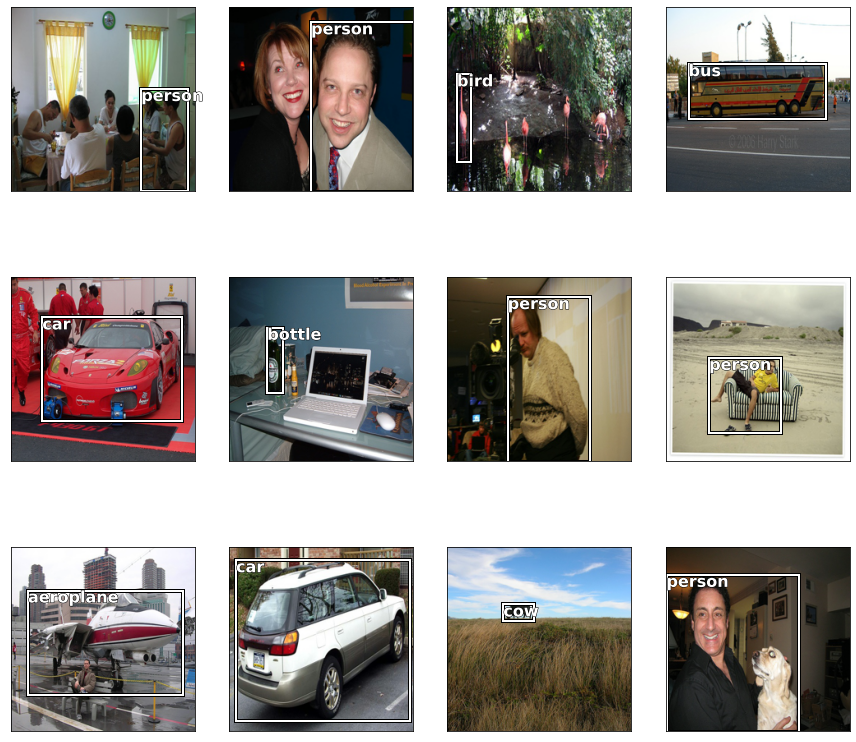

In [59]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x_batch,y_batch = next(iter(valid_gen))
    bb = y_batch[0][i]
    cat = y_batch[1][i]    
    image = x_batch[i]

    c = np.argmax(cat)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb))
    draw_text(ax, [bb[1],bb[0]], train_gen.class_name[c], sz=16)

plt.tight_layout()

### 3.2: The model

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

Notice, the importance of Keras functional API. With sequential API, this multi-output model is not possible.

In [60]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
 
y = net.output
y = Flatten()(y)
y = Dropout(0.5)(y)

# branch for the regression --> BBox
output_layer_bbox = Dense(4, activation='linear', name='layer_bbox')(y)

# Branch for the classification --> Category
output_layer_class = Dense(train_gen.NbClasses, activation='softmax', name='layer_class')(y)

model = Model(inputs=net.input, outputs=[output_layer_bbox,output_layer_class])

### 3.3: The optimizer

Here, we need to combine the two Loss function for each branch.
Because each Loss will have different range, it is then better to set a weight on each of them.
We can check from the previous individual training to put the weight accordingly so that each branch has the same influence

In [61]:
optimizer=Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss=['mean_absolute_error','categorical_crossentropy'], metrics=['accuracy'],loss_weights=[1., 5.])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

### 3.4: Time to train

In [62]:
epochs = 20

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

print(history.history.keys())

Epoch 1/20
27/27 [==============================] - 25s 718ms/step - loss: 223.3919 - layer_bbox_loss: 82.1615 - layer_class_loss: 28.2461 - layer_bbox_accuracy: 0.3600 - layer_class_accuracy: 0.1661 - val_loss: 116.6168 - val_layer_bbox_loss: 52.3565 - val_layer_class_loss: 12.8521 - val_layer_bbox_accuracy: 0.4517 - val_layer_class_accuracy: 0.3722
Epoch 2/20
27/27 [==============================] - 19s 697ms/step - loss: 118.8048 - layer_bbox_loss: 45.4170 - layer_class_loss: 14.6776 - layer_bbox_accuracy: 0.5324 - layer_class_accuracy: 0.3814 - val_loss: 88.6802 - val_layer_bbox_loss: 42.7080 - val_layer_class_loss: 9.1944 - val_layer_bbox_accuracy: 0.5795 - val_layer_class_accuracy: 0.5014
Epoch 3/20
27/27 [==============================] - 19s 694ms/step - loss: 86.7374 - layer_bbox_loss: 41.2271 - layer_class_loss: 9.1021 - layer_bbox_accuracy: 0.5961 - layer_class_accuracy: 0.5318 - val_loss: 80.4434 - val_layer_bbox_loss: 40.0306 - val_layer_class_loss: 8.0826 - val_layer_bbox

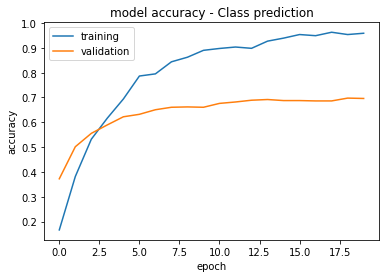

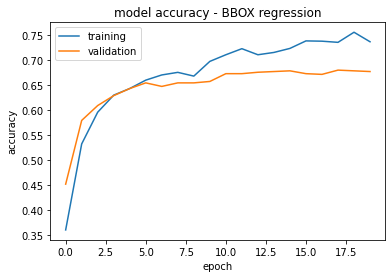

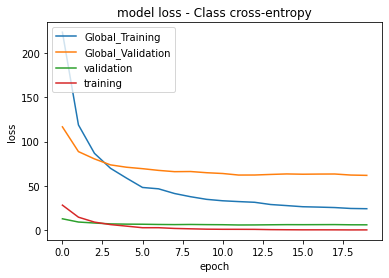

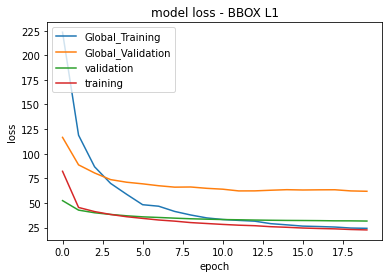

In [63]:
# summarize history for accuracy for Class
plt.plot(history.history['layer_class_accuracy'])
plt.plot(history.history['val_layer_class_accuracy'])
plt.title('model accuracy - Class prediction')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for accuracy for bbox regression
plt.plot(history.history['layer_bbox_accuracy'])
plt.plot(history.history['val_layer_bbox_accuracy'])
plt.title('model accuracy - BBOX regression')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for loss for Class
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_class_loss'])
plt.plot(history.history['layer_class_loss'])
plt.title('model loss - Class cross-entropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

# summarize history for loss for BBOX
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_bbox_loss'])
plt.plot(history.history['layer_bbox_loss'])
plt.title('model loss - BBOX L1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

### 3.5: unfreeze few layers

In [64]:
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
optimizer=Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss=['mean_absolute_error','categorical_crossentropy'], 
              metrics=['accuracy'],loss_weights=[1., 20.])
 

epochs = 20

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

Epoch 1/20
27/27 [==============================] - 20s 721ms/step - loss: 28.7213 - layer_bbox_loss: 22.3395 - layer_class_loss: 0.3191 - layer_bbox_accuracy: 0.7593 - layer_class_accuracy: 0.9647 - val_loss: 149.8055 - val_layer_bbox_loss: 31.5892 - val_layer_class_loss: 5.9108 - val_layer_bbox_accuracy: 0.6861 - val_layer_class_accuracy: 0.6974
Epoch 2/20
27/27 [==============================] - 19s 690ms/step - loss: 28.3523 - layer_bbox_loss: 21.9980 - layer_class_loss: 0.3177 - layer_bbox_accuracy: 0.7593 - layer_class_accuracy: 0.9624 - val_loss: 146.7246 - val_layer_bbox_loss: 31.4162 - val_layer_class_loss: 5.7654 - val_layer_bbox_accuracy: 0.6804 - val_layer_class_accuracy: 0.7045
Epoch 3/20
27/27 [==============================] - 19s 723ms/step - loss: 25.7972 - layer_bbox_loss: 21.7030 - layer_class_loss: 0.2047 - layer_bbox_accuracy: 0.7610 - layer_class_accuracy: 0.9711 - val_loss: 142.3215 - val_layer_bbox_loss: 31.2672 - val_layer_class_loss: 5.5527 - val_layer_bbox_ac

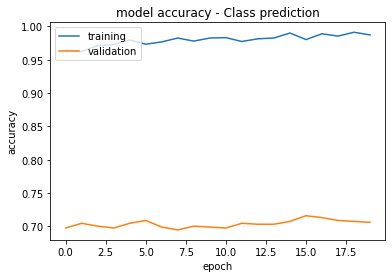

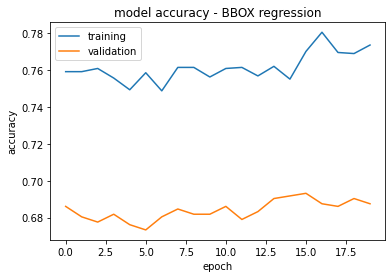

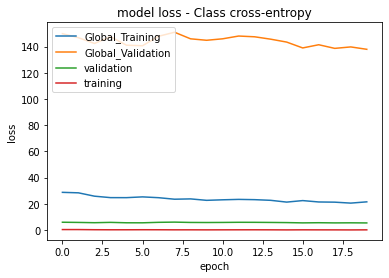

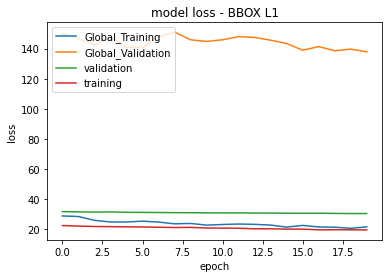

In [65]:
# summarize history for accuracy for Class
plt.plot(history.history['layer_class_accuracy'])
plt.plot(history.history['val_layer_class_accuracy'])
plt.title('model accuracy - Class prediction')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for accuracy for bbox regression
plt.plot(history.history['layer_bbox_accuracy'])
plt.plot(history.history['val_layer_bbox_accuracy'])
plt.title('model accuracy - BBOX regression')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for loss for Class
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_class_loss'])
plt.plot(history.history['layer_class_loss'])
plt.title('model loss - Class cross-entropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

# summarize history for loss for BBOX
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_bbox_loss'])
plt.plot(history.history['layer_bbox_loss'])
plt.title('model loss - BBOX L1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

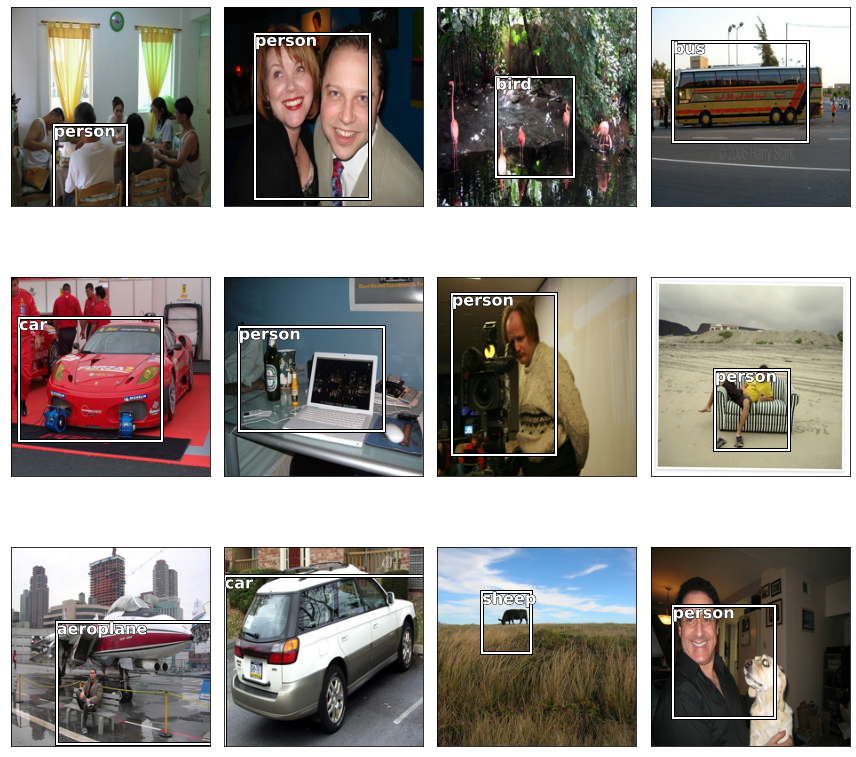

In [66]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x_batch,y_batch = next(iter(iter(valid_gen)))
    image = x_batch[i]
    model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)

    bb = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)[0][0]
    cat =model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)[1][0]   
    

    c = np.argmax(cat)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb))
    draw_text(ax, [bb[1],bb[0]], train_gen.class_name[c], sz=16)

plt.tight_layout()

### Later we will enhance this model and use advanced techniques ex. yolo v4  to infer real time images